# Learning Kinetics from Time Series Data

This notebook is an implementation of Kinetic Learning created by Zak Costello.

## TODO for Publication

### Code Functionality:
1. Develop a Data Set to simulate the method for testing.
    * [X] Trouble Shoot Data Generation Function to figure out why Integration is failing...
2. [X] Implement Kinetic Model Prediction + Plot Prediction on Experimental Prediction Plots
3. [X] Add RMSE Metrics For Kinetic Model and report

### Code Quality:
1. [X] Rewrite and Simplify Code.
2. [X] Add to Version control.

### Paper Writing:

1. [X] Normalize Axes On Big Simulated Data Plot

3. Update Figures for Each Simulation to Mirror Most Up to Date Version
    * [X] Improve Simulated Figures (Add Legend + Make Target more noticable)
    * [X] Simulated / Simple
    * [X] Simulated / Limonene
    * [X] Experimental / Limonene
    * [X] Experimental / Isopentenol
6. [X] Incorporate Kinetic Model Comparisons into Existing Experimental data set plots (if they are even at all close)

7. [X] Make All plots write out files and save all data generated!

Savitzsky golay filter citation:
@article{savitzky1964smoothing,
  title={Smoothing and differentiation of data by simplified least squares procedures.},
  author={Savitzky, Abraham and Golay, Marcel JE},
  journal={Analytical chemistry},
  volume={36},
  number={8},
  pages={1627--1639},
  year={1964},
  publisher={ACS Publications}
}

## Ideas for Future:
1. Implement Code in tensor flow (with a better machine learning model...)
2. Expand number of pathway models -- show i can learn simulated data for many pathways
3. Optimize titer using this method directly inferred from data!

# 1. Set Flags For Running Code
Four data sets are supported in this code.  Two are simulated, and two are from experimental data. Change the set_num variable below to choose which data set to fit.

In [1]:
#Choose the data set to run
data_sets = [('simulated','small'),          #Small Canonical Pathway Model with Feedback Inhibition 
             ('simulated','limonene'),        #Large Limonene Model Developed Based on the Literature
             ('experimental','isopentenol'),  #Experimental Isopentenol Pathway Time Series Data
             ('experimental','limonene')]     #Experimental Limonene Pathway Time Series Data

set_num = 1

The Machine Learning Model is determined by these flags.  The features to use can be automatic or manual and the machine learning model can be chosen. Additionally, the random seed can be set.

In [2]:
feature_selection = 'Automatic'   #Manual or Automatic: Manual has hand selected features, Autmatic uses an algorithm
machine_learning_model = 'tpot'   #neural,random_forest(RF)

#Set Random Seed for deterministic Execution
seed = None #If seed is set then output will be deterministic (And results can be cached for faster execution)

#Time Consuming, will be cached for each unique case. (Only Relevant for experimental Limonene Pathway)
run_kinetic_model = True #Allows for comparison between ml model and kinetic model performance

Variables to Set For Simulated Data Sets (How Many Strains and how many training sets needed

In [3]:
#Relevant if Simulated
data_type,pathway = data_sets[set_num]
if data_sets[set_num][0] == 'simulated':
    strain_numbers = [2,10,100]
    training_sets = 20 #Change to support a variable number here (I want to shoot for 10...)
    
    #Strains Needed Calculation
    strains_needed = (max(strain_numbers) + 1)*training_sets + 1 + 2000
    print(strains_needed)
    
    #Calculation of training_size values
    train_sizes = []
    for strain_number in strain_numbers:
        train_size = (strain_number + 1) * training_sets / (strains_needed - 1)
        train_sizes.append(train_size)
    print(train_sizes)
    
    print([int((strains_needed-1)*size/training_sets)-1 for size in train_sizes])
    #Strains Required

    training_strains = strains_needed
    test_strains = 1200

elif data_type == 'experimental':
    pass


#Plotting Options (If set true more extensive plots are created for troubleshooting purposes)
Plot_Data = False

4021
[0.014925373134328358, 0.05472636815920398, 0.5024875621890548]
[2, 10, 100]


# 2. Import Modules & Setup
Importing all required modules and helper functions

In [4]:
%matplotlib inline
from plot import *
from helper import *
from IPython.display import display
from sklearn.base import clone
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import differential_evolution
import math
import sys
sys.path.append('/usr/local/lib/python3.5/site-packages')

# 3. Load & Format Data into DataFrame

In [5]:
if data_type == 'simulated':
    if pathway == 'limonene':
        file_name = 'data/Fulld10000n0.csv'
        y0 = [1e-5]*10
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['AtoB','HMGR','HMGS','MK','PMK','PMD','Idi','GPPS','LS']
        targets=['Acetyl-CoA','Acetoacetyl-CoA','HMG-CoA','Mev','MevP','MevPP','IPP','DMAPP','GPP','Limonene']
        specific_features = {'Acetyl-CoA':      ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR'],
                             'Acetoacetyl-CoA': ['AtoB','Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMG-CoA'],
                             'HMG-CoA':         ['Acetyl-CoA','Acetoacetyl-CoA','HMGR','HMGS','HMG-CoA'],
                             'Mev':             ['Acetyl-CoA','Acetoacetyl-CoA','HMGS','HMG-CoA','MK','Mev','GPP','MevP'],
                             'MevP':            ['MK','Mev','GPP','MevP','PMK'],
                             'MevPP':           ['PMK','MevP','PMD','MevPP','Mev'],
                             'IPP':             ['PMD','MevPP','MevP','Mev','Idi','IPP','GPPS','DMAPP'],
                             'DMAPP':           ['Idi','IPP','GPPS','DMAPP'],
                             'GPP':             ['GPPS','IPP','DMAPP','GPP','LS'],
                             'Limonene':        ['LS','GPP']}

        #Create TSDF for training strains
        tsdf = generateTSDataSet(df,features,targets)
        
        #Create Validation TSDF to test the models predictive power
        test_tsdf = generateTSDataSet(test_df,features,targets)
        display(test_tsdf)
        
    elif pathway=='small':
        file_name = 'data/SmallKineticsd30000n0.csv'
        y0 = [0.2]*3
        timeKey = 'Time'
        df = pd.read_csv(file_name)
        df = df.pivot_table(df,index=['Strain','Time'],aggfunc=np.sum)

        strains = df.index.get_level_values(0).unique()
        sample = random.sample(list(strains),training_strains+test_strains)

        #create test df
        test_df = df.loc[(sample[0:test_strains],slice(None))]

        #create the training df
        df = df.loc[(sample[test_strains:],slice(None))]

        features = ['e0','e1']
        targets=['s0','s1','s2']
        specific_features = {'s0': ['e0','e1','s0','s1','s2'],
                             's1': ['e0','e1','s0','s1','s2'],
                             's2': ['e0','e1','s0','s1','s2']}

        tsdf = generateTSDataSet(df,features,targets)
    
elif data_type == 'experimental':
    if pathway == 'limonene':
        #Parameters that Can Be Set:
        strains = ['L1','L2','L3']
        training_strains = ['L1','L3']
        test_strains = ['L2']

        #Define Machine Learning Targets & Features To Use

        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Limonene g/L']
        features = ['OD600','ATP (uM)','AtoB','Limonene Synthase','HMGR','HMGS','MK','PMK','PMD','GPP (uM)',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','Limonene Synthase','Limonene g/L'],
                             'Limonene g/L':['OD600','ATP (uM)','Limonene Synthase','Limonene g/L','GPP (uM)']}

    elif pathway == 'isopentenol':
        #Parameters that Can Be Set:
        strains = ['I1','I2','I3']
        training_strains = ['I1','I3']
        test_strains = ['I2']
        
        targets = ['Acetyl-CoA (uM)','HMG-CoA (uM)','Intracellular Mevalonate (uM)','Mev-P (uM)','IPP/DMAPP (uM)','Isopentenol g/L']
        features = ['OD600','ATP (uM)','AtoB','NudB','HMGR','HMGS','MK','PMK','PMD',
                    'NAD (uM)','NADP (uM)','Acetate g/L','Pyruvate g/L','citrate (uM)']

        specific_features = {'Acetyl-CoA (uM)':['OD600','ATP (uM)','AtoB','HMGR','HMGS', 'Acetyl-CoA (uM)', 'HMG-CoA (uM)','Pyruvate g/L','citrate (uM)'],
                             'HMG-CoA (uM)':['OD600','HMG-CoA (uM)','HMGR','MK','Mev-P (uM)','Intracellular Mevalonate (uM)','NAD (uM)','NADP (uM)'],
                             'Intracellular Mevalonate (uM)':['OD600','ATP (uM)','Intracellular Mevalonate (uM)','MK','PMK','Mev-P (uM)'],
                             'Mev-P (uM)':['OD600','ATP (uM)','PMD','Mev-P (uM)','Intracellular Mevalonate (uM)','IPP/DMAPP (uM)'],
                             'IPP/DMAPP (uM)':['OD600','ATP (uM)','IPP/DMAPP (uM)','NudB','Isopentenol g/L'],
                             'Isopentenol g/L':['OD600','ATP (uM)','NudB','Isopentenol g/L','IPP/DMAPP (uM)']}

    
    #Processing Data Files and Creating a Shared Dataframe
    metabolite_file_name = 'data/time_series_metabolomics.csv'
    protein_file_name = 'data/time_series_proteomics.csv'

    mdf = pd.read_csv(metabolite_file_name)
    pdf = pd.read_csv(protein_file_name)

    #Format protein tables
    proteins = ['AtoB','HMGR','HMGS','MK','PMD','PMK','Idi','GPPS','Limonene Synthase','NudB']
    proteins = [('ProteinArea',protein) for protein in proteins]
    columns = ['Strain','Time','Protein','ProteinArea']

    pdf = pdf.loc[pdf['Strain'].isin(strains)]
    pdf = pdf.loc[~pdf['Hour'].isin(['72C'])]
    pdf['Hour'] = pdf['Hour'].convert_objects(convert_numeric=True)

    pdf.rename(columns={'Hour': 'Time'}, inplace=True)    
    display(pdf)
    print(columns)

    pdf = pdf[columns].pivot_table(pdf[columns],index=['Strain','Time'],columns='Protein',aggfunc=np.sum)
    pdf = pdf[proteins]
    pdf.columns = pdf.columns.get_level_values(1)
    
    #Format metabolite tables
    metabolites = ['Acetyl-CoA (uM)','Acetyl-CoA extracellular (uM)',
                   'Acetoacetyl-coA (uM)','Acetoacetyl-CoA extracellular (uM)',
                   'HMG-CoA (uM)','HMG-CoA extracellular (uM)',
                   'Intracellular Mevalonate (uM)','MEVALONATE extracellular (uM)',
                   'Mev-P (uM)','MEV-P extracellular (uM)',
                   'IPP/DMAPP (uM)','IPP/DMAPP extracellular (uM)',
                   'GPP (uM)','GPP extracellular (uM)',
                   'Limonene g/L','ATP (uM)','OD600','NAD (uM)','NADP (uM)',
                   'Acetate g/L','Pyruvate g/L','citrate (uM)','Isopentenol g/L']

    mdf = mdf.loc[mdf['Strain'].isin(strains)]
    
    mdf.rename(columns={'Hour': 'Time'}, inplace=True)
    mdf = mdf[['Strain','Time'] + metabolites].pivot_table(mdf[['Strain','Time'] + metabolites],index=['Strain','Time'],aggfunc=np.sum)
    
    #Extracellular Metabolites (mg/L) | Intracelluar Metabolites (mg/L) |Combined Metabolites (mg/L)

    #Join metabolite and protein tables
    df = pd.concat([pdf, mdf], axis=1)
    test_df = df.loc[(test_strains,slice(None))]
    display(test_df)
    df = df.loc[(training_strains,slice(None))]
    tsdf = generateTSDataSet(df,features,targets,n_points=200)

Total Time Series in Data Set:  4021


/Users/zakcostello/anaconda/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


Total Time Series in Data Set:  1200


feature                                               \
                 Acetoacetyl-CoA Acetyl-CoA          AtoB     DMAPP       GPP   
Strain Time (h)                                                                 
2      0.000000         0.200001   0.200037  5.390390e+05  0.200000  0.200015   
       0.696970         0.200006   0.209271  3.005258e+06  0.199932  0.199833   
       1.393939         0.200008   0.218406  4.842658e+06  0.199872  0.199625   
       2.090909         0.200008   0.227442  6.051239e+06  0.199820  0.199391   
       2.787879         0.200005   0.236348  6.227423e+06  0.199778  0.199119   
       3.484848         0.200000   0.245191  6.259495e+06  0.199742  0.198834   
       4.181818         0.199994   0.253989  6.340651e+06  0.199713  0.198546   
       4.878788         0.199987   0.262748  6.410525e+06  0.199686  0.198255   
       5.575758         0.199980   0.271471  6.463212e+06  0.199663  0.197963   
       6.272727         0.199973   0.280155  6.504040e+06  0.199642  0.197669   
       6.969697         0.199965   0.288805  6.537568e+06  0.199622  0.197374   
       7.666667         0.199957   0.297425  6.565602e+06  0.199604  0.197079   
       8.363636         0.199949   0.306011  6.588763e+06  0.199588  0.196785   
       9.060606         0.199941   0.314565  6.608400e+06  0.199573  0.196491   
       9.757576         0.199934   0.323092  6.625629e+06  0.199558  0.196197   
       10.454545        0.199926   0.331590  6.640497e+06  0.199545  0.195904   
       11.151515        0.199918   0.340058  6.653468e+06  0.199532  0.195612   
       11.848485        0.199911   0.348500  6.665074e+06  0.199521  0.195321   
       12.545455        0.199904   0.356915  6.675422e+06  0.199510  0.195031   
       13.242424        0.199897   0.365303  6.684644e+06  0.199499  0.194742   
       13.939394        0.199890   0.373665  6.692984e+06  0.199489  0.194454   
       14.636364        0.199883   0.382003  6.700586e+06  0.199480  0.194168   
       15.333333        0.199877   0.390315  6.707472e+06  0.199471  0.193883   
       16.030303        0.199871   0.398601  6.713756e+06  0.199463  0.193599   
       16.727273        0.199865   0.406865  6.719566e+06  0.199455  0.193317   
       17.424242        0.199859   0.415105  6.724899e+06  0.199448  0.193035   
       18.121212        0.199854   0.423321  6.729809e+06  0.199441  0.192756   
       18.818182        0.199849   0.431515  6.734391e+06  0.199434  0.192478   
       19.515152        0.199845   0.439687  6.738649e+06  0.199428  0.192201   
       20.212121        0.199841   0.447835  6.742603e+06  0.199422  0.191926   
...                          ...        ...           ...       ...       ...   
9993   48.787879        0.069788   0.681634  4.520284e+06  0.198328  0.193343   
       49.484848        0.067815   0.687988  4.521328e+06  0.198323  0.193344   
       50.181818        0.065864   0.694357  4.522342e+06  0.198318  0.193348   
       50.878788        0.063937   0.700741  4.523330e+06  0.198314  0.193353   
       51.575758        0.062033   0.707139  4.524292e+06  0.198310  0.193359   
       52.272727        0.060156   0.713556  4.525228e+06  0.198307  0.193368   
       52.969697        0.058307   0.719992  4.526139e+06  0.198304  0.193378   
       53.666667        0.056485   0.726447  4.527029e+06  0.198302  0.193390   
       54.363636        0.054694   0.732923  4.527895e+06  0.198300  0.193404   
       55.060606        0.052935   0.739424  4.528738e+06  0.198299  0.193420   
       55.757576        0.051206   0.745947  4.529562e+06  0.198298  0.193437   
       56.454545        0.049511   0.752495  4.530366e+06  0.198297  0.193456   
       57.151515        0.047852   0.759071  4.531149e+06  0.198297  0.193476   
       57.848485        0.046228   0.765674  4.531915e+06  0.198297  0.193498   
       58.545455        0.044639   0.772304  4.532663e+06  0.198298  0.193521   
       59.242424        0.043090   0.778965  4.533393e+0

In [6]:
display(df)

Acetoacetyl-CoA  Acetyl-CoA          AtoB     DMAPP       GPP  \
Strain Time                                                                  
7      0            0.200000    0.200000  7.914290e+00  0.200000  0.200000   
       1            0.197708    0.211130  5.032832e+06  0.199819  0.200011   
       2            0.194420    0.220749  6.253280e+06  0.199605  0.199941   
       3            0.190849    0.229874  6.803199e+06  0.199390  0.199846   
       4            0.187096    0.238684  7.116097e+06  0.199172  0.199746   
       5            0.183199    0.247249  7.318043e+06  0.198953  0.199651   
       6            0.179177    0.255606  7.459165e+06  0.198732  0.199563   
       7            0.175045    0.263780  7.563345e+06  0.198509  0.199486   
       8            0.170812    0.271788  7.643410e+06  0.198285  0.199419   
       9            0.166487    0.279644  7.706864e+06  0.198058  0.199364   
       10           0.162077    0.287358  7.758391e+06  0.197830  0.199320   
       11           0.157588    0.294941  7.801065e+06  0.197601  0.199288   
       12           0.153028    0.302402  7.836987e+06  0.197371  0.199267   
       13           0.148401    0.309748  7.867642e+06  0.197139  0.199258   
       14           0.143715    0.316989  7.894109e+06  0.196907  0.199259   
       15           0.138975    0.324131  7.917192e+06  0.196673  0.199270   
       16           0.134187    0.331182  7.937500e+06  0.196440  0.199290   
       17           0.129357    0.338150  7.955506e+06  0.196205  0.199320   
       18           0.124491    0.345041  7.971579e+06  0.195971  0.199359   
       19           0.119597    0.351864  7.986016e+06  0.195736  0.199405   
       20           0.114680    0.358627  7.999055e+06  0.195501  0.199460   
       21           0.109747    0.365336  8.010888e+06  0.195267  0.199521   
       22           0.104807    0.372001  8.021676e+06  0.195032  0.199589   
       23           0.099866    0.378630  8.031551e+06  0.194797  0.199663   
       24           0.094935    0.385232  8.040624e+06  0.194563  0.199743   
       25           0.090020    0.391817  8.048990e+06  0.194329  0.199828   
       26           0.085133    0.398395  8.056728e+06  0.194096  0.199918   
       27           0.080284    0.404976  8.063906e+06  0.193863  0.200013   
       28           0.075483    0.411573  8.070582e+06  0.193630  0.200111   
       29           0.070743    0.418197  8.076809e+06  0.193398  0.200213   
...                      ...         ...           ...       ...       ...   
10000  40           0.007829    0.492335  7.017875e+06  0.188486  0.193420   
       41           0.006922    0.502823  7.019952e+06  0.188158  0.193335   
       42           0.006228    0.513488  7.021932e+06  0.187830  0.193253   
       43           0.005709    0.524286  7.023820e+06  0.187502  0.193175   
       44           0.005326    0.535182  7.025624e+06  0.187172  0.193100   
       45           0.005051    0.546147  7.027348e+06  0.186842  0.193028   
       46           0.004857    0.557155  7.028998e+06  0.186511  0.192959   
       47           0.004726    0.568187  7.030579e+06  0.186180  0.192893   
       48           0.004642    0.579228  7.032094e+06  0.185848  0.192830   
       49           0.004593    0.590268  7.033548e+06  0.185516  0.192770   
       50           0.004570    0.601297  7.034945e+06  0.185183  0.192712   
       51           0.004567    0.612309  7.036287e+06  0.184850  0.192658   
       52           0.004578    0.623300  7.037579e+06  0.184516  0.192606   
       53           0.004600    0.634267  7.038821e+06  0.184182  0.192557   
       54           0.004629    0.645206  7.040019e+06  0.183847  0.192510   
       55           0.004663    0.656116  7.041173e+06  0.183513  0.192466   
       56           0.004702    0.666997  7.042286e+06  0.183177  0.192424   
       57           0.004743    0.677848  7.043361e+06  0.182842  0.192385   
       58           0.004785    0.6

# 4. Construct Machine Learning Models
First Do Feature Selection if Automatic features are selected.

In [7]:
#Automatic Feature Selection using Recursive Feature Selection cross validated with a Random Forest Regressor
if feature_selection == 'automatic':
    estimator = RandomForestRegressor()
    specific_features = {}
    feature_list = [('feature',feature) for feature in features + targets]
    for target in targets:
        
        #display(tsdf[feature_list].ix[:100])
        if data_type == 'simulated':
            X = tsdf[feature_list].ix[:2000].values.tolist()
            y = tsdf[('target',target)].ix[:2000].values.tolist()        
        else:
            X = tsdf[feature_list].values.tolist()
            y = tsdf[('target',target)].values.tolist()
            
        selector = RFECV(estimator,verbose=1)
        selector.fit(X,y)
        mask = selector.get_support()
        specific_features[target] = [feature for i,feature in enumerate(features + targets) if mask[i]]
        print(target,specific_features[target])

Define all Possible Machine Learning Models that can be used in the analysis.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit

#Create Models for Each Target Column
modelDict = {}

#Pipeline Regressors
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
supportVectorRegressor = Pipeline([('Scaler',StandardScaler()),
                               ('SVR',SVR())])

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
polynomialRegressor = Pipeline([('Scaler',StandardScaler()),
                                ('Polynomial Features',PolynomialFeatures(degree=3, include_bias=True, interaction_only=True)),
                                ('Feature Reduction',RFECV(Ridge(),cv=None, scoring='r2')),
                                ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                     n_estimators=100, max_samples=.8,
                                                                     bootstrap=False,
                                                                     bootstrap_features=False,
                                                                     random_state=None))])

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
featureReducingRF = Pipeline([('Feature Reduction',SelectKBest(mutual_info_regression, k=4)),
                              ('Random Forest Regressor',RandomForestRegressor())])


model_str = machine_learning_model
featureReduction = False
if model_str == 'SVR':
    mlmodel = supportVectorRegressor
elif model_str == 'RF':
    mlmodel = RandomForestRegressor(n_estimators=20)
elif model_str == 'Poly':
    mlmodel = polynomialRegressor
elif model_str == 'Bagging':
    mlmodel = BaggingRegressor(base_estimator=supportVectorRegressor)
elif model_str == 'FeatRF':
    mlmodel = featureReducingRF 
    featureReduction = True
elif model_str == 'Log':
    LogScale = FunctionTransformer(np.log1p)
    mlmodel = Pipeline([('Log Transform',LogScale),('Scaler',StandardScaler()),
                        ('Linear',LassoLarsIC())])
elif model_str == 'neural':
    neural_model = Pipeline([('Scaler',StandardScaler()),
                               ('neural_net',MLPRegressor(hidden_layer_sizes=(5,5,5),
                                                          learning_rate_init=0.1,
                                                          learning_rate='adaptive',
                                                          solver='sgd',
                                                          activation='tanh',
                                                          max_iter=1000))])
    #mlmodel = MLPRegressor(hidden_layer_sizes=(10,10),learning_rate_init=0.1,solver='lbfgs')
    mlmodel= neural_model
    
elif model_str == 'gaussian':
    mlmodel = Pipeline([('Scaler',StandardScaler()),
                        ('gassian',GaussianProcessRegressor(normalize_y=True))])
elif model_str == 'tpot':
    from tpot import TPOTRegressor
    #mlmodel = TPOTRegressor(generations=130, population_size=100, verbosity=2,max_time_mins=20,cv=ShuffleSplit(),scoring='r2',n_jobs=1)
    #mlmodel = TPOTRegressor(generations=130, population_size=80, verbosity=2,cv=ShuffleSplit(),n_jobs=1,max_time_mins=35)
    mlmodel = TPOTRegressor(generations=12, population_size=30, verbosity=2,cv=ShuffleSplit(),n_jobs=1)#,max_time_mins=10)
    

## 5. Fitting & Evaluating Machine Learning Models

For both simulated and real data we calculate the goodness of fit of the machine learning models. For Simulated Data we calculate the following Metrics which help us evaluate goodness of fit.

Simulated Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives (Combined Vector Derivative Error RMSE)
3. Goodness of Fit Plot For Simulated Curves
4. RMSE for all simulated curves, Figure out the right one to report (Seperate and together -- Normalized / Percent / Regular)

Experimental Data Results:
1. Learning Curves for Derivatives
2. Error Distribution for Derivatives, (Combined Vector)
3. Comparison Plot between Real and Predicted Curves
4. RMSE for Single Predicted Curve, (By Metabolite and Combined)

Acetoacetyl-CoA


Optimization Progress:  15%|█▌        | 60/390 [07:57<2:38:40, 28.85s/pipeline]

Generation 1 - Current best internal CV score: 1.9587658494211266e-08


Optimization Progress:  23%|██▎       | 90/390 [11:00<1:39:52, 19.97s/pipeline]

Generation 2 - Current best internal CV score: 1.6184434166237175e-08


Optimization Progress:  31%|███       | 121/390 [28:37<2:10:54, 29.20s/pipeline] 

Generation 3 - Current best internal CV score: 1.6184434166237175e-08


Optimization Progress:  39%|███▉      | 152/390 [45:09<5:29:51, 83.16s/pipeline] 

Generation 4 - Current best internal CV score: 1.6184434166237175e-08


Optimization Progress:  47%|████▋     | 182/390 [51:52<40:03, 11.55s/pipeline]  

Generation 5 - Current best internal CV score: 1.0622715305459263e-08


Optimization Progress:  54%|█████▍    | 212/390 [54:20<21:38,  7.30s/pipeline]

Generation 6 - Current best internal CV score: 1.0598468102534617e-08


Optimization Progress:  62%|██████▏   | 242/390 [1:00:11<2:03:41, 50.15s/pipeline]

Generation 7 - Current best internal CV score: 1.0598468102534617e-08


Optimization Progress:  70%|██████▉   | 272/390 [1:03:38<08:52,  4.51s/pipeline]  

Generation 8 - Current best internal CV score: 9.932080921675314e-09


Optimization Progress:  77%|███████▋  | 302/390 [1:06:28<07:43,  5.27s/pipeline]

Generation 9 - Current best internal CV score: 9.087312606419928e-09


Optimization Progress:  85%|████████▌ | 332/390 [1:09:14<03:22,  3.50s/pipeline]

Generation 10 - Current best internal CV score: 9.087312606419928e-09


Optimization Progress:  93%|█████████▎| 362/390 [1:13:34<02:22,  5.09s/pipeline]

Generation 11 - Current best internal CV score: 8.13193874681717e-09


Generation 12 - Current best internal CV score: 8.13193874681717e-09

Best pipeline: KNeighborsRegressor(ElasticNetCV(Normalizer(ZeroCount(input_matrix), norm=l1), l1_ratio=0.2, tol=0.01), n_neighbors=2, p=2, weights=distance)
Acetoacetyl-CoA


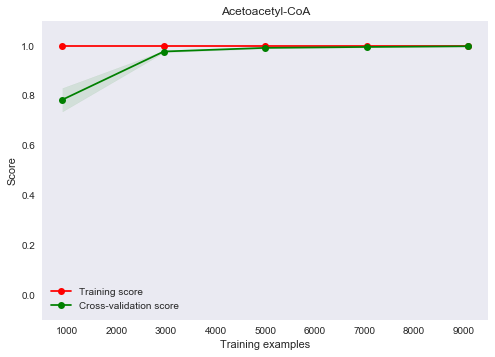

Cross Validated Pearson R: 1.000000
Acetyl-CoA


Optimization Progress:  15%|█▌        | 60/390 [17:28<2:43:21, 29.70s/pipeline]

Generation 1 - Current best internal CV score: 1.8786629367206665e-08


Optimization Progress:  23%|██▎       | 90/390 [22:00<27:23,  5.48s/pipeline]  

Generation 2 - Current best internal CV score: 1.8786629367206665e-08


Optimization Progress:  31%|███       | 120/390 [27:02<12:45,  2.84s/pipeline]  

Generation 3 - Current best internal CV score: 1.682197844276011e-08


Optimization Progress:  38%|███▊      | 150/390 [34:46<32:54,  8.23s/pipeline]  

Generation 4 - Current best internal CV score: 1.5018743403673242e-08


Optimization Progress:  46%|████▌     | 180/390 [49:34<49:52, 14.25s/pipeline]  

Generation 5 - Current best internal CV score: 1.5018743403673242e-08


Optimization Progress:  54%|█████▍    | 210/390 [54:48<25:37,  8.54s/pipeline]

Generation 6 - Current best internal CV score: 1.5018743403673242e-08


Optimization Progress:  62%|██████▏   | 240/390 [1:05:51<49:49, 19.93s/pipeline]  

Generation 7 - Current best internal CV score: 1.5018743403673242e-08


Optimization Progress:  69%|██████▉   | 270/390 [1:17:57<46:50, 23.42s/pipeline]  

Generation 8 - Current best internal CV score: 1.5018743403673242e-08


Optimization Progress:  77%|███████▋  | 300/390 [1:31:37<33:13, 22.15s/pipeline]  

Generation 9 - Current best internal CV score: 1.4693004959256532e-08


Optimization Progress:  85%|████████▍ | 330/390 [1:49:15<22:11, 22.20s/pipeline]  

Generation 10 - Current best internal CV score: 1.4693004959256532e-08


Optimization Progress:  93%|█████████▎| 361/390 [2:06:59<20:22, 42.17s/pipeline]   

Generation 11 - Current best internal CV score: 1.4693004959256532e-08


Generation 12 - Current best internal CV score: 1.395370491898957e-08

Best pipeline: ExtraTreesRegressor(ElasticNetCV(GradientBoostingRegressor(input_matrix, alpha=0.9, learning_rate=0.1, loss=quantile, max_depth=9, max_features=0.5, min_samples_leaf=20, min_samples_split=5, n_estimators=100, subsample=0.65), l1_ratio=0.35, tol=0.01), bootstrap=False, max_features=0.35, min_samples_leaf=1, min_samples_split=11, n_estimators=100)
Acetyl-CoA


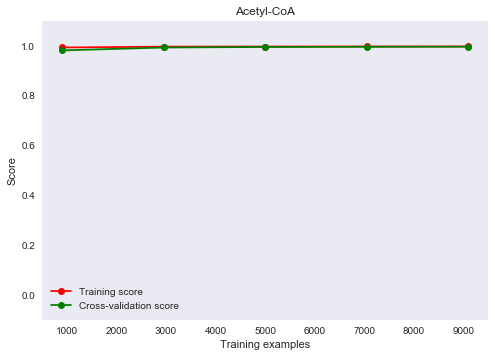

Cross Validated Pearson R: 0.997411
DMAPP


Optimization Progress:  15%|█▌        | 60/390 [05:17<12:41,  2.31s/pipeline]  

Generation 1 - Current best internal CV score: 2.3797958795000974e-10


Optimization Progress:  23%|██▎       | 91/390 [13:17<20:59,  4.21s/pipeline]  

Generation 2 - Current best internal CV score: 2.1989829073220683e-10


Optimization Progress:  31%|███       | 121/390 [13:42<02:24,  1.87pipeline/s]

Generation 3 - Current best internal CV score: 1.6625406543950286e-10


Optimization Progress:  39%|███▊      | 151/390 [14:37<01:48,  2.19pipeline/s]

Generation 4 - Current best internal CV score: 1.2566486807438427e-10


Optimization Progress:  46%|████▋     | 181/390 [15:35<04:59,  1.43s/pipeline]

Generation 5 - Current best internal CV score: 1.2566486807438427e-10


Optimization Progress:  54%|█████▍    | 211/390 [16:35<01:50,  1.63pipeline/s]

Generation 6 - Current best internal CV score: 1.1580546643445456e-10


Optimization Progress:  62%|██████▏   | 241/390 [16:57<01:11,  2.08pipeline/s]

Generation 7 - Current best internal CV score: 1.1580546643445456e-10


Optimization Progress:  69%|██████▉   | 271/390 [17:24<01:01,  1.94pipeline/s]

Generation 8 - Current best internal CV score: 1.1580546643445456e-10


Optimization Progress:  77%|███████▋  | 301/390 [18:58<01:41,  1.14s/pipeline]

Generation 9 - Current best internal CV score: 1.1580546643445456e-10


Optimization Progress:  85%|████████▍ | 331/390 [20:21<02:15,  2.29s/pipeline]

Generation 10 - Current best internal CV score: 6.230963655957022e-11


Optimization Progress:  93%|█████████▎| 361/390 [21:55<01:08,  2.35s/pipeline]

Generation 11 - Current best internal CV score: 6.230963655957022e-11


Generation 12 - Current best internal CV score: 4.6613078687737575e-11

Best pipeline: KNeighborsRegressor(SelectFwe(SelectPercentile(Normalizer(input_matrix, norm=l2), percentile=47), alpha=0.046), n_neighbors=1, p=2, weights=distance)
DMAPP


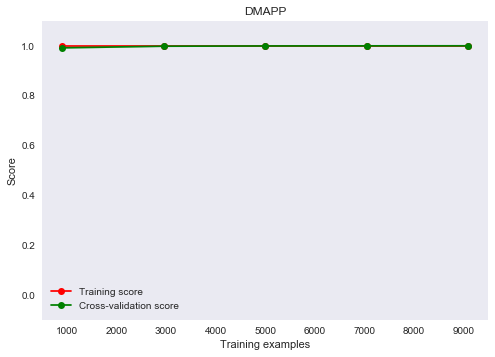

Cross Validated Pearson R: 1.000000
GPP


Optimization Progress:  15%|█▌        | 60/390 [03:10<37:18,  6.78s/pipeline]

Generation 1 - Current best internal CV score: 2.1808272553362167e-09


Optimization Progress:  23%|██▎       | 90/390 [07:13<20:54,  4.18s/pipeline]  

Generation 2 - Current best internal CV score: 5.780819011499438e-10


Optimization Progress:  31%|███       | 120/390 [09:14<29:03,  6.46s/pipeline]

Generation 3 - Current best internal CV score: 5.780819011499438e-10


Optimization Progress:  38%|███▊      | 150/390 [10:38<22:36,  5.65s/pipeline]

Generation 4 - Current best internal CV score: 5.780819011499438e-10


Optimization Progress:  46%|████▌     | 180/390 [12:34<13:59,  4.00s/pipeline]

Generation 5 - Current best internal CV score: 5.780819011499438e-10


Optimization Progress:  54%|█████▍    | 210/390 [13:43<14:00,  4.67s/pipeline]

Generation 6 - Current best internal CV score: 3.566461455250902e-10


Optimization Progress:  62%|██████▏   | 240/390 [15:36<09:23,  3.76s/pipeline]

Generation 7 - Current best internal CV score: 3.566461455250902e-10


Optimization Progress:  69%|██████▉   | 270/390 [18:35<02:11,  1.09s/pipeline]  

Generation 8 - Current best internal CV score: 1.0546921558871948e-10


Optimization Progress:  77%|███████▋  | 300/390 [19:42<01:49,  1.21s/pipeline]

Generation 9 - Current best internal CV score: 1.0546921558871948e-10


Optimization Progress:  85%|████████▍ | 330/390 [20:53<02:37,  2.63s/pipeline]

Generation 10 - Current best internal CV score: 1.0546921558871948e-10


Optimization Progress:  92%|█████████▏| 360/390 [22:46<03:12,  6.41s/pipeline]

Generation 11 - Current best internal CV score: 1.0546921558871948e-10


Generation 12 - Current best internal CV score: 1.0546921558871948e-10

Best pipeline: KNeighborsRegressor(Normalizer(input_matrix, norm=max), n_neighbors=1, p=1, weights=distance)
GPP


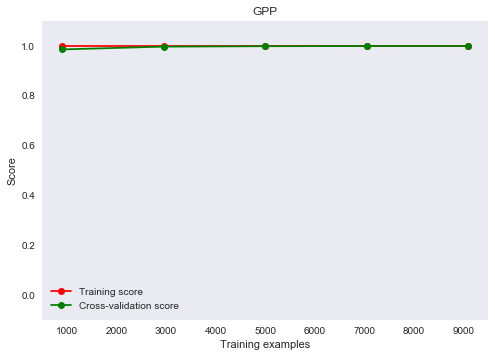

Cross Validated Pearson R: 1.000000
HMG-CoA


Optimization Progress:  15%|█▌        | 60/390 [08:58<26:18,  4.78s/pipeline]  

Generation 1 - Current best internal CV score: 2.528423273707988e-08


Optimization Progress:  23%|██▎       | 90/390 [14:42<46:04,  9.21s/pipeline]  

Generation 2 - Current best internal CV score: 2.2095594258012725e-08


Optimization Progress:  31%|███       | 120/390 [25:35<1:40:09, 22.26s/pipeline]

Generation 3 - Current best internal CV score: 2.2095594258012725e-08


Optimization Progress:  38%|███▊      | 150/390 [16:50:40<3:37:49, 54.46s/pipeline]     

Generation 4 - Current best internal CV score: 1.7809992305877632e-08


Optimization Progress:  46%|████▋     | 181/390 [17:33:18<3:11:35, 55.00s/pipeline]  

Generation 5 - Current best internal CV score: 1.7809992305877632e-08


Optimization Progress:  54%|█████▍    | 211/390 [17:48:13<1:51:24, 37.35s/pipeline]

Generation 6 - Current best internal CV score: 1.7809992305877632e-08


Optimization Progress:  62%|██████▏   | 241/390 [18:01:47<1:35:19, 38.38s/pipeline]

Generation 7 - Current best internal CV score: 1.191546791899792e-08


Optimization Progress:  69%|██████▉   | 271/390 [18:16:56<1:11:27, 36.03s/pipeline]

Generation 8 - Current best internal CV score: 1.0880451843151932e-08


Optimization Progress:  78%|███████▊  | 303/390 [18:43:41<53:25, 36.85s/pipeline]   

Generation 9 - Current best internal CV score: 1.0880451843151932e-08


Optimization Progress:  85%|████████▌ | 333/390 [18:58:14<34:24, 36.23s/pipeline]

Generation 10 - Current best internal CV score: 1.0880451843151932e-08


Optimization Progress:  94%|█████████▍| 366/390 [19:26:03<12:45, 31.89s/pipeline]   

Generation 11 - Current best internal CV score: 1.0742993176415703e-08


Generation 12 - Current best internal CV score: 1.0574864030496414e-08

Best pipeline: LassoLarsCV(ExtraTreesRegressor(RobustScaler(input_matrix), bootstrap=False, max_features=0.4, min_samples_leaf=4, min_samples_split=7, n_estimators=100), normalize=True)
HMG-CoA


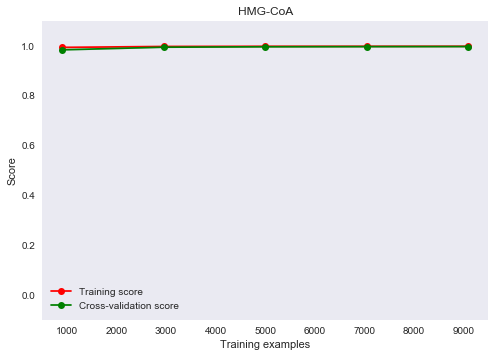

Cross Validated Pearson R: 0.997968
IPP


Optimization Progress:  15%|█▌        | 60/390 [06:45<22:30,  4.09s/pipeline]  

Generation 1 - Current best internal CV score: 2.8492249997992977e-08


Optimization Progress:  23%|██▎       | 90/390 [12:36<28:56,  5.79s/pipeline]  

Generation 2 - Current best internal CV score: 2.4267872362225575e-08


Optimization Progress:  31%|███       | 120/390 [17:12<1:51:04, 24.68s/pipeline]

Generation 3 - Current best internal CV score: 2.236251513141578e-08


Optimization Progress:  38%|███▊      | 150/390 [24:35<1:09:15, 17.31s/pipeline]

Generation 4 - Current best internal CV score: 1.9392523427569272e-08


Optimization Progress:  46%|████▌     | 180/390 [32:04<28:22,  8.11s/pipeline]  

Generation 5 - Current best internal CV score: 1.623178534721223e-08


Optimization Progress:  54%|█████▍    | 210/390 [42:42<39:14, 13.08s/pipeline]  

Generation 6 - Current best internal CV score: 1.623178534721223e-08


Optimization Progress:  62%|██████▏   | 240/390 [52:22<1:30:21, 36.14s/pipeline]

Generation 7 - Current best internal CV score: 1.623178534721223e-08


Optimization Progress:  69%|██████▉   | 270/390 [57:52<19:30,  9.76s/pipeline]  

Generation 8 - Current best internal CV score: 1.6189404881767085e-08


Optimization Progress:  77%|███████▋  | 301/390 [1:10:52<1:18:39, 53.03s/pipeline] 

Generation 9 - Current best internal CV score: 1.5464862585779567e-08


Optimization Progress:  85%|████████▍ | 331/390 [1:18:09<10:16, 10.45s/pipeline]  

Generation 10 - Current best internal CV score: 1.4933050104966134e-08


Optimization Progress:  93%|█████████▎| 361/390 [1:24:43<02:57,  6.13s/pipeline]

Generation 11 - Current best internal CV score: 1.4208598344169408e-08


Generation 12 - Current best internal CV score: 1.4073204594455945e-08

Best pipeline: LassoLarsCV(RobustScaler(ExtraTreesRegressor(ExtraTreesRegressor(input_matrix, bootstrap=True, max_features=1.0, min_samples_leaf=2, min_samples_split=8, n_estimators=100), bootstrap=True, max_features=1.0, min_samples_leaf=2, min_samples_split=11, n_estimators=100)), normalize=False)
IPP


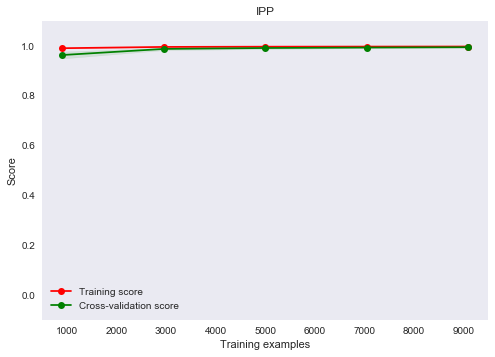

Cross Validated Pearson R: 0.996923
Limonene


Optimization Progress:  15%|█▌        | 60/390 [00:43<05:00,  1.10pipeline/s]

Generation 1 - Current best internal CV score: 1.2836485514999216e-09


Optimization Progress:  23%|██▎       | 90/390 [01:28<11:13,  2.24s/pipeline]

Generation 2 - Current best internal CV score: 1.2836485514999216e-09


Optimization Progress:  31%|███       | 120/390 [01:55<04:35,  1.02s/pipeline]

Generation 3 - Current best internal CV score: 9.464287824995958e-10


Optimization Progress:  38%|███▊      | 150/390 [02:20<02:06,  1.90pipeline/s]

Generation 4 - Current best internal CV score: 9.038976633751525e-10


Optimization Progress:  46%|████▌     | 180/390 [02:53<06:34,  1.88s/pipeline]

Generation 5 - Current best internal CV score: 9.038976633751525e-10


Optimization Progress:  54%|█████▍    | 210/390 [03:36<02:17,  1.31pipeline/s]

Generation 6 - Current best internal CV score: 8.268640852009134e-10


Optimization Progress:  62%|██████▏   | 240/390 [04:18<05:30,  2.20s/pipeline]

Generation 7 - Current best internal CV score: 4.299414396642021e-10


Optimization Progress:  69%|██████▉   | 270/390 [05:15<02:40,  1.34s/pipeline]

Generation 8 - Current best internal CV score: 2.3309940994386986e-10


Optimization Progress:  77%|███████▋  | 300/390 [06:42<05:45,  3.83s/pipeline]

Generation 9 - Current best internal CV score: 2.3309940994386986e-10


Optimization Progress:  85%|████████▍ | 330/390 [09:43<12:18, 12.31s/pipeline]

Generation 10 - Current best internal CV score: 2.02410048800416e-10


Optimization Progress:  92%|█████████▏| 360/390 [12:38<02:11,  4.37s/pipeline]

Generation 11 - Current best internal CV score: 2.02410048800416e-10


Generation 12 - Current best internal CV score: 1.9952824192290986e-10

Best pipeline: LassoLarsCV(DecisionTreeRegressor(GradientBoostingRegressor(PolynomialFeatures(input_matrix, degree=2, include_bias=False, interaction_only=False), alpha=0.75, learning_rate=0.1, loss=lad, max_depth=3, max_features=0.85, min_samples_leaf=3, min_samples_split=10, n_estimators=100, subsample=0.2), max_depth=10, min_samples_leaf=16, min_samples_split=16), normalize=True)
Limonene


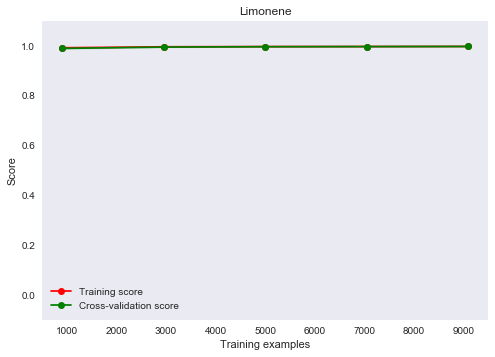

Cross Validated Pearson R: 0.996866
Mev


Optimization Progress:  15%|█▌        | 60/390 [06:47<51:08,  9.30s/pipeline]  

Generation 1 - Current best internal CV score: 4.407756157939284e-08


Optimization Progress:  23%|██▎       | 90/390 [10:47<17:43,  3.55s/pipeline]  

Generation 2 - Current best internal CV score: 3.342749341828314e-08


Optimization Progress:  31%|███       | 120/390 [17:24<1:33:44, 20.83s/pipeline]

Generation 3 - Current best internal CV score: 3.342749341828314e-08


Optimization Progress:  38%|███▊      | 150/390 [26:08<44:45, 11.19s/pipeline]  

Generation 4 - Current best internal CV score: 3.342749341828314e-08


Optimization Progress:  46%|████▌     | 180/390 [35:48<55:10, 15.76s/pipeline]  

Generation 5 - Current best internal CV score: 3.156698517892609e-08


Optimization Progress:  54%|█████▍    | 210/390 [47:56<1:30:42, 30.24s/pipeline]

Generation 6 - Current best internal CV score: 3.156698517892609e-08


Optimization Progress:  62%|██████▏   | 240/390 [58:34<59:51, 23.94s/pipeline]  

Generation 7 - Current best internal CV score: 3.156698517892609e-08


Optimization Progress:  69%|██████▉   | 271/390 [1:17:44<1:06:32, 33.55s/pipeline] 

Generation 8 - Current best internal CV score: 3.156698517892609e-08


Optimization Progress:  77%|███████▋  | 302/390 [1:35:35<1:34:18, 64.30s/pipeline] 

Generation 9 - Current best internal CV score: 3.148269590152485e-08


Optimization Progress:  85%|████████▌ | 332/390 [1:47:27<45:08, 46.70s/pipeline]  

Generation 10 - Current best internal CV score: 2.9772467327182467e-08


Optimization Progress:  93%|█████████▎| 363/390 [2:04:03<21:15, 47.26s/pipeline]   

Generation 11 - Current best internal CV score: 2.8026173217153904e-08


Generation 12 - Current best internal CV score: 2.8026173217153904e-08

Best pipeline: ExtraTreesRegressor(PolynomialFeatures(StandardScaler(input_matrix), degree=2, include_bias=False, interaction_only=False), bootstrap=False, max_features=0.8, min_samples_leaf=2, min_samples_split=17, n_estimators=100)
Mev


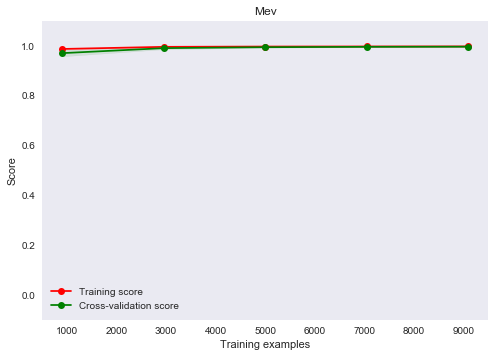

Cross Validated Pearson R: 0.997449
MevP


Optimization Progress:  15%|█▌        | 60/390 [06:58<31:25,  5.71s/pipeline]  

Generation 1 - Current best internal CV score: 4.7729105051846695e-08


Optimization Progress:  23%|██▎       | 90/390 [10:51<10:53,  2.18s/pipeline]  

Generation 2 - Current best internal CV score: 4.57339918711809e-08


Optimization Progress:  31%|███       | 120/390 [20:27<2:29:12, 33.16s/pipeline]

Generation 3 - Current best internal CV score: 4.57339918711809e-08


Optimization Progress:  38%|███▊      | 150/390 [31:14<1:35:14, 23.81s/pipeline]

Generation 4 - Current best internal CV score: 4.57339918711809e-08


Optimization Progress:  46%|████▌     | 180/390 [41:05<57:44, 16.50s/pipeline]  

Generation 5 - Current best internal CV score: 4.57339918711809e-08


Optimization Progress:  54%|█████▍    | 210/390 [51:18<36:17, 12.10s/pipeline]  

Generation 6 - Current best internal CV score: 3.9325146160394374e-08


Optimization Progress:  62%|██████▏   | 240/390 [56:13<20:38,  8.26s/pipeline]  

Generation 7 - Current best internal CV score: 3.2004879654529806e-08


Optimization Progress:  69%|██████▉   | 270/390 [1:02:44<18:18,  9.15s/pipeline]

Generation 8 - Current best internal CV score: 2.8233481527144327e-08


Optimization Progress:  77%|███████▋  | 300/390 [1:10:52<17:23, 11.60s/pipeline]  

Generation 9 - Current best internal CV score: 2.8233481527144327e-08


Optimization Progress:  85%|████████▍ | 330/390 [1:19:24<08:37,  8.62s/pipeline]

Generation 10 - Current best internal CV score: 2.8233481527144327e-08


Optimization Progress:  92%|█████████▏| 360/390 [1:28:20<10:48, 21.61s/pipeline]

Generation 11 - Current best internal CV score: 2.8233481527144327e-08


Generation 12 - Current best internal CV score: 2.8233481527144327e-08

Best pipeline: ExtraTreesRegressor(CombineDFs(StandardScaler(Binarizer(input_matrix, threshold=0.75)), input_matrix), bootstrap=False, max_features=0.85, min_samples_leaf=2, min_samples_split=7, n_estimators=100)
MevP


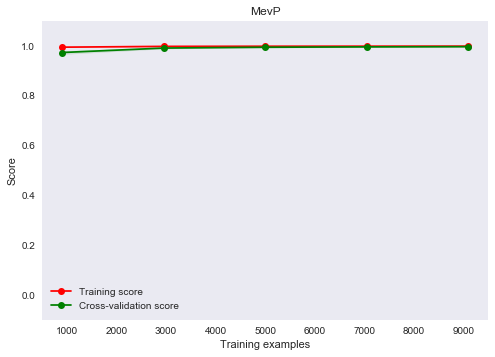

Cross Validated Pearson R: 0.998307
MevPP


Optimization Progress:  15%|█▌        | 60/390 [07:50<42:33,  7.74s/pipeline]  

Generation 1 - Current best internal CV score: 2.7392276073123746e-08


Optimization Progress:  23%|██▎       | 90/390 [23:49<1:00:42, 12.14s/pipeline]

Generation 2 - Current best internal CV score: 2.7392276073123746e-08


Optimization Progress:  31%|███       | 120/390 [43:18<1:10:03, 15.57s/pipeline]

Generation 3 - Current best internal CV score: 2.7392276073123746e-08


Optimization Progress:  38%|███▊      | 150/390 [1:03:29<1:50:28, 27.62s/pipeline]

Generation 4 - Current best internal CV score: 2.1938895434883773e-08


Optimization Progress:  46%|████▌     | 180/390 [1:29:01<2:11:53, 37.68s/pipeline] 

Generation 5 - Current best internal CV score: 2.1938895434883773e-08


Optimization Progress:  55%|█████▍    | 213/390 [1:57:29<1:23:12, 28.21s/pipeline] 

Generation 6 - Current best internal CV score: 2.1938895434883773e-08


Optimization Progress:  62%|██████▏   | 243/390 [2:13:59<1:01:14, 25.00s/pipeline]

Generation 7 - Current best internal CV score: 2.1938895434883773e-08


Optimization Progress:  71%|███████   | 275/390 [2:38:41<53:31, 27.92s/pipeline]   

Generation 8 - Current best internal CV score: 2.1938895434883773e-08


Optimization Progress:  78%|███████▊  | 305/390 [2:50:44<43:59, 31.05s/pipeline]  

Generation 9 - Current best internal CV score: 2.1938895434883773e-08


Optimization Progress:  86%|████████▌ | 335/390 [3:01:51<19:32, 21.31s/pipeline]

Generation 10 - Current best internal CV score: 1.9180117064061136e-08


Optimization Progress:  94%|█████████▍| 366/390 [3:13:57<07:42, 19.28s/pipeline]   

Generation 11 - Current best internal CV score: 1.9180117064061136e-08


Generation 12 - Current best internal CV score: 1.9180117064061136e-08

Best pipeline: ExtraTreesRegressor(ElasticNetCV(input_matrix, l1_ratio=0.5, tol=0.1), bootstrap=True, max_features=0.55, min_samples_leaf=1, min_samples_split=5, n_estimators=100)
MevPP


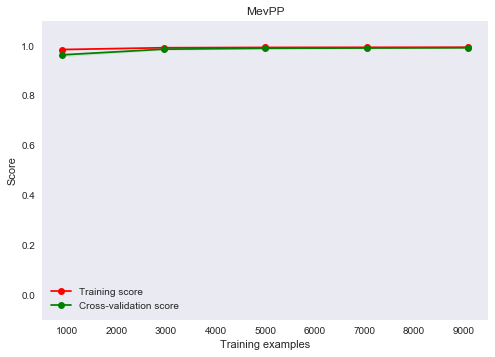

Cross Validated Pearson R: 0.994010
Average Training Score: 0.997893418968 n: 10


In [9]:
#1. Calculate Learning Curves for Derivatives

#Pick number of strains so that the total number is equal to max tested strains...
if data_type == 'simulated':
    strains = tsdf.index.get_level_values(0).unique()
    tsdf_max_strains = tsdf.loc[slice(strains[0],strains[max(strain_numbers)]),slice(None)]
else:
    tsdf_max_strains = tsdf

average_training_score = 0
n = 0
for target_index in tsdf_max_strains.columns:
    if target_index[0] == 'feature':
        continue
    n += 1
    target = target_index[1]
    print(target)


    #feature_indecies = [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains['feature'].values.tolist()
    y = tsdf_max_strains[target_index].values.tolist()

    #if fit_log_targets:
    #    y = [math.log(val) for val in y]
    
    #print(X)
    #print(y)
    if model_str == 'tpot':
        modelDict[target] = clone(mlmodel).fit(np.array(X),np.array(y)).fitted_pipeline_
        try:
            crossValPlot = plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
        except:
            pass
    else:
        modelDict[target] = clone(mlmodel)
        crossValPlot = plot_learning_curve(modelDict[target],target,X,y,cv=ShuffleSplit())
    
    ax = plt.gca()
    ax.set_ylim([-0.1, 1.1])
    strip_target = ''.join([char for char in target if char != '/'])
    print(strip_target)
    crossValPlot.savefig('figures/' + strip_target + 'CrossValPlot.pdf',transparent=False)
    plt.show()
    
    #Save out Cross Validation Plot
    
    modelDict[target] = modelDict[target].fit(X,y)
    
    score = modelDict[target].score(X,y)
    print('Cross Validated Pearson R: {:f}'.format(score))
    average_training_score +=  score
    #print(modelDict[target_name].predict([reduced_features[2]]))
    
average_training_score /= n
print('Average Training Score:',average_training_score,'n:',n)

Total Time Series in Data Set:  1200


feature                                               \
                 Acetoacetyl-CoA Acetyl-CoA          AtoB     DMAPP       GPP   
Strain Time (h)                                                                 
2      0.000000         0.200001   0.200037  5.390390e+05  0.200000  0.200015   
       0.696970         0.200006   0.209271  3.005258e+06  0.199932  0.199833   
       1.393939         0.200008   0.218406  4.842658e+06  0.199872  0.199625   
       2.090909         0.200008   0.227442  6.051239e+06  0.199820  0.199391   
       2.787879         0.200005   0.236348  6.227423e+06  0.199778  0.199119   
       3.484848         0.200000   0.245191  6.259495e+06  0.199742  0.198834   
       4.181818         0.199994   0.253989  6.340651e+06  0.199713  0.198546   
       4.878788         0.199987   0.262748  6.410525e+06  0.199686  0.198255   
       5.575758         0.199980   0.271471  6.463212e+06  0.199663  0.197963   
       6.272727         0.199973   0.280155  6.504040e+06  0.199642  0.197669   
       6.969697         0.199965   0.288805  6.537568e+06  0.199622  0.197374   
       7.666667         0.199957   0.297425  6.565602e+06  0.199604  0.197079   
       8.363636         0.199949   0.306011  6.588763e+06  0.199588  0.196785   
       9.060606         0.199941   0.314565  6.608400e+06  0.199573  0.196491   
       9.757576         0.199934   0.323092  6.625629e+06  0.199558  0.196197   
       10.454545        0.199926   0.331590  6.640497e+06  0.199545  0.195904   
       11.151515        0.199918   0.340058  6.653468e+06  0.199532  0.195612   
       11.848485        0.199911   0.348500  6.665074e+06  0.199521  0.195321   
       12.545455        0.199904   0.356915  6.675422e+06  0.199510  0.195031   
       13.242424        0.199897   0.365303  6.684644e+06  0.199499  0.194742   
       13.939394        0.199890   0.373665  6.692984e+06  0.199489  0.194454   
       14.636364        0.199883   0.382003  6.700586e+06  0.199480  0.194168   
       15.333333        0.199877   0.390315  6.707472e+06  0.199471  0.193883   
       16.030303        0.199871   0.398601  6.713756e+06  0.199463  0.193599   
       16.727273        0.199865   0.406865  6.719566e+06  0.199455  0.193317   
       17.424242        0.199859   0.415105  6.724899e+06  0.199448  0.193035   
       18.121212        0.199854   0.423321  6.729809e+06  0.199441  0.192756   
       18.818182        0.199849   0.431515  6.734391e+06  0.199434  0.192478   
       19.515152        0.199845   0.439687  6.738649e+06  0.199428  0.192201   
       20.212121        0.199841   0.447835  6.742603e+06  0.199422  0.191926   
...                          ...        ...           ...       ...       ...   
9993   48.787879        0.069788   0.681634  4.520284e+06  0.198328  0.193343   
       49.484848        0.067815   0.687988  4.521328e+06  0.198323  0.193344   
       50.181818        0.065864   0.694357  4.522342e+06  0.198318  0.193348   
       50.878788        0.063937   0.700741  4.523330e+06  0.198314  0.193353   
       51.575758        0.062033   0.707139  4.524292e+06  0.198310  0.193359   
       52.272727        0.060156   0.713556  4.525228e+06  0.198307  0.193368   
       52.969697        0.058307   0.719992  4.526139e+06  0.198304  0.193378   
       53.666667        0.056485   0.726447  4.527029e+06  0.198302  0.193390   
       54.363636        0.054694   0.732923  4.527895e+06  0.198300  0.193404   
       55.060606        0.052935   0.739424  4.528738e+06  0.198299  0.193420   
       55.757576        0.051206   0.745947  4.529562e+06  0.198298  0.193437   
       56.454545        0.049511   0.752495  4.530366e+06  0.198297  0.193456   
       57.151515        0.047852   0.759071  4.531149e+06  0.198297  0.193476   
       57.848485        0.046228   0.765674  4.531915e+06  0.198297  0.193498   
       58.545455        0.044639   0.772304  4.532663e+06  0.198298  0.193521   
       59.242424        0.043090   0.778965  4.533393e+0

Acetoacetyl-CoA Mean Error: 0.000602516636398 Error Standard Deviation: 0.00256855225368


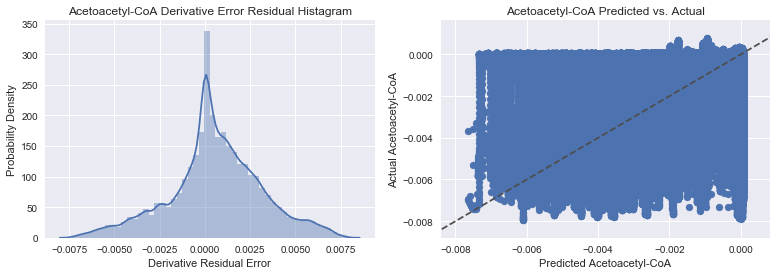

Acetyl-CoA Mean Error: -4.21206778836e-06 Error Standard Deviation: 0.000288916893228


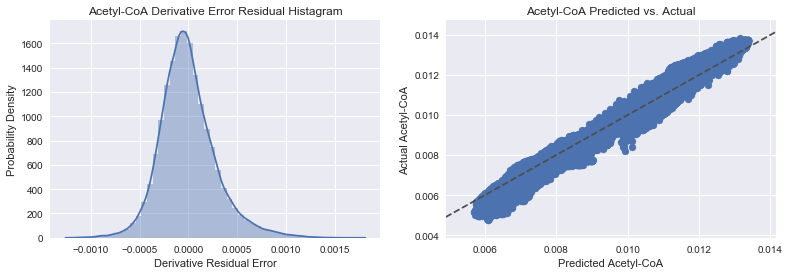

DMAPP Mean Error: -1.12005371413e-05 Error Standard Deviation: 0.000235151046435


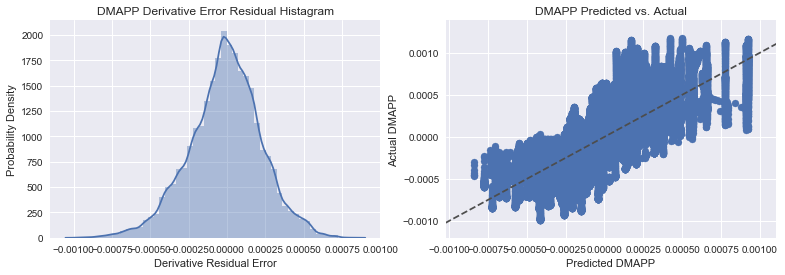

GPP Mean Error: -7.33937937752e-05 Error Standard Deviation: 0.000279083352792


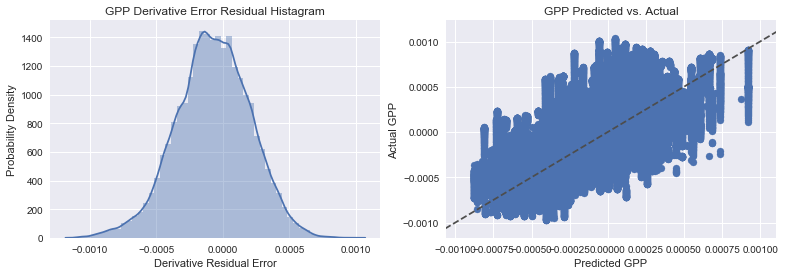

HMG-CoA Mean Error: 8.7247516031e-05 Error Standard Deviation: 0.000314048935292


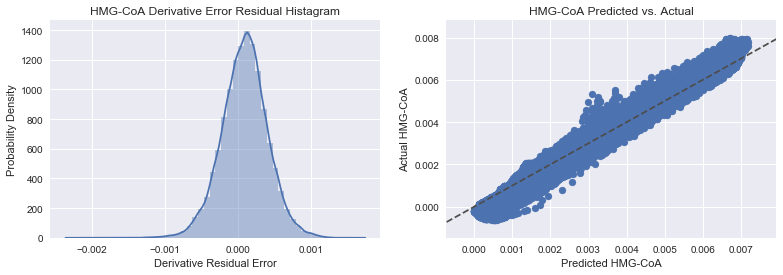

IPP Mean Error: 5.46984002159e-05 Error Standard Deviation: 0.000367572598001


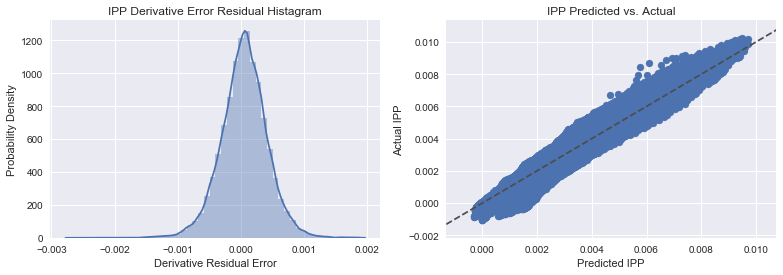

Limonene Mean Error: 1.26503490494e-06 Error Standard Deviation: 1.64345807411e-05


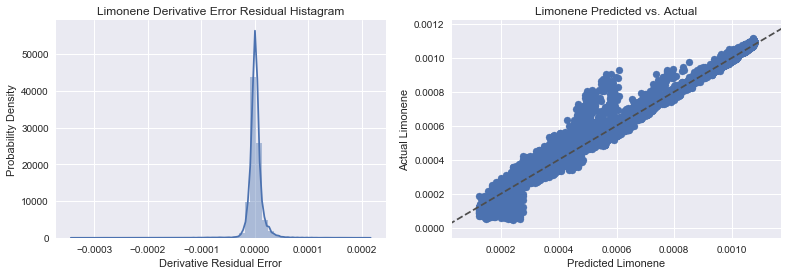

Mev Mean Error: -4.29670337135e-05 Error Standard Deviation: 0.000239870647065


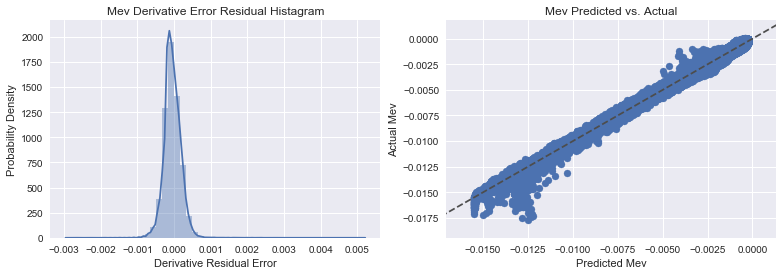

MevP Mean Error: 2.21009087437e-05 Error Standard Deviation: 0.000375245840439


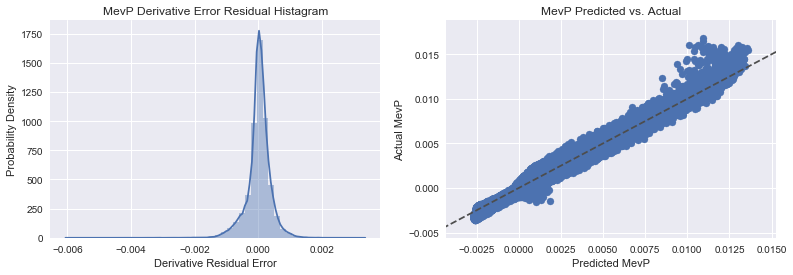

MevPP Mean Error: -4.24854711355e-05 Error Standard Deviation: 0.00027081819651


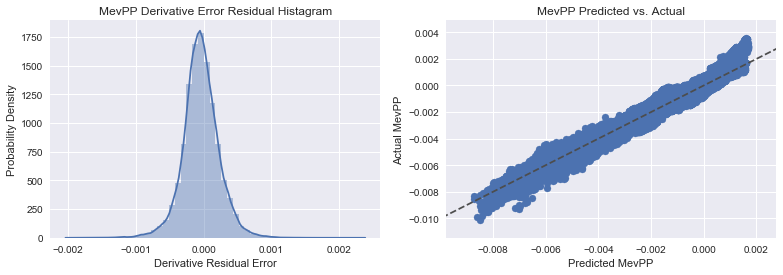

Total Derivative Mean Error: 0.00229023629947 Error Standard Deviation: 0.00156777951229


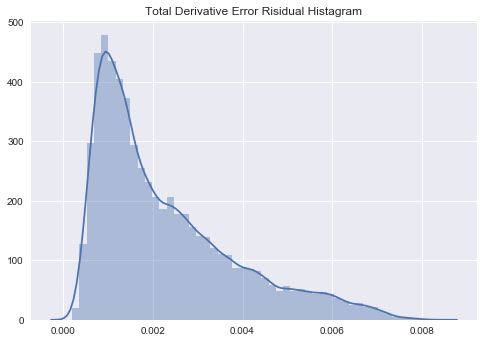

In [10]:
#2. Calculate Error Distribution and Plot + Report Moments
ts_test_df = generateTSDataSet(test_df,features,targets)
display(ts_test_df)
errors = []
for target in modelDict:
    times,y_test = remove_NaN(ts_test_df.reset_index()['Time (h)'].values,ts_test_df[('target',target)].values)
    
    feature_list = [('feature',feature) for feature in tsdf['feature'].columns]
    target_df = ts_test_df[feature_list]
    target_df = target_df[ts_test_df.index.get_level_values('Time (h)').isin(times)]
    
    #Check to make sure there are no NaNs in each feature
    for feature in target_df.columns:
        if any([math.isnan(val) for val in target_df[feature].values]):
            X,y = remove_NaN(target_df.reset_index()['Time'].values,target_df[feature].values)
            fnc = interp1d(X,y)
        index = 0
        for time,val in zip(times,target_df[feature].values):
            if math.isnan(val):
                #print(feature,time,fnc(time))
                target_df[feature].iloc[index] = fnc(time)
            index += 1
    #display(target_df)
    
    y_prediction = modelDict[target].predict(target_df.values)
    
    #print(y_prediction)
    #print(y_test)
    log_error = [math.log(max(y_p,0.0001)) - math.log(max(y_t,0.0001)) for y_p,y_t in zip(y_prediction,y_test)]
    error = [y_p - y_t for y_p,y_t in zip(y_prediction,y_test)]
    errors.append(error)
    
    mu = np.mean(error)
    sigma = np.std(error)
    print(target,'Mean Error:',mu,'Error Standard Deviation:',sigma)
    
    plt.figure(figsize=(13,4))
    plt.subplot(121)
    sns.distplot(error)
    plt.title(target + ' Derivative '+ 'Error Residual Histagram')
    plt.xlabel('Derivative Residual Error')
    plt.ylabel('Probability Density')
    
    plt.subplot(122)
    plot_model_fit(target,y_prediction,y_test)
    
    strip_target = ''.join([char for char in target if char != '/'])
    plt.savefig('figures/' + strip_target + 'ErrorResiduals.pdf')
    plt.show()
    
    #modelDict[target].predict()

#Compute Net Error Magnitude
error_magnitude = [0]*len(errors[0])
for error in errors:
    error_magnitude = [em + e**2 for em,e in zip(error_magnitude,error)]
error_magnitude = [math.sqrt(e) for e in error_magnitude]
mu = np.mean(error_magnitude)
sigma = np.std(error_magnitude)
print('Total Derivative','Mean Error:',mu,'Error Standard Deviation:',sigma)
    
sns.distplot(error_magnitude)
plt.title('Total Derivative Error Risidual Histagram')
plt.show()

In [11]:
# If Experimental Limonene Results show that the Hand created 
# Kinetic Model Does not fit as well as the machine learning model

def proteomicsData(t,k):
    e = []
    for i in range(int(len(k)/3)):
        #Sorting the gains to ensure proteins only increase
        gains = sorted(k[3*i:3*(i+1)],reverse=True)
        e.append(leaky_hill_fcn(t,*gains)) 
    return e


def kinetic_model(e1,e2,e3,e4,e5,e6,e7,e8,e9,
                  s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,
                  k11,k12,k13,k21,k22,k23,k24,k31,k32,k33,k34,k35,
                  k41,k42,k43,k44,k45,k51,k52,k61,k62,k63,k64,k65,
                  k71,k72,k81,k82,k83,k84,k91,k92,Vin,ks3):
    r1 = Vin - (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r2 = (k11*e1*s1)/(k12 + k13*s1) - k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2)
    r3 = k21*e2*s1*s2*ks3 / (k22*s2 + k23*s1 + k24*s1*s2) - k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35)
    r4 = k31*e3*s3 / (k32*s1 + k33*s2 + k34*s3 + k35) - k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45)
    r5 = k41*e4*s4 / (k42*s9 + k43*s5 + k44*s4 + k45) - k51*e5*s5 / (k52 + s5)
    r6 = k51*e5*s5 / (k52 + s5) - k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65)
    r7 = k61*e6*s6 / (k62*s5 + k63*s4 + k64*s6 + k65) - k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r8 = k71*e7*s7 / (k72 + s7) - k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8)
    r9 = k81*e8*s7*s8 / (k82 + k83*s7 + k84*s8 + s7*s8) - k91*e9*s9 / (k92 + s9)
    r10 = k91*e9*s9 / (k92 + s9)
    return [r1,r2,r3,r4,r5,r6,r7,r8,r9,r10]
    
def solve_kinetic_ode(f,y0,times,k_fit):
    sol = 1
    return sol

measured_substrates = ['Acetyl-CoA (uM)', 'HMG-CoA (uM)', 'Intracellular Mevalonate (uM)', 'Mev-P (uM)', 'IPP/DMAPP (uM)', 'Limonene g/L']
measured_enzymes = ['AtoB', 'HMGS', 'HMGR', 'MK', 'PMK', 'PMD', 'Limonene Synthase']
x_features = [('feature',val) for val in measured_enzymes+measured_substrates]
y_targets = [('target',val) for val in measured_substrates]

#print(x_features)
#print(y_targets)

if data_type == 'experimental' and  pathway == 'limonene':
    [('feature', feature) for feature in specific_features[target]]
    X = tsdf_max_strains[x_features].values.tolist()
    y = tsdf_max_strains[y_targets].values.tolist()
    
    #Solve for Kinetic Coefficients from Training Set
    def cost_fcn_gen(X,y):
        def cost_fcn(free_params):
            cost = 0
            for x_val,y_vals in zip(X,y):
                params = []
                params.extend(x_val[0:6])       # AtoB to PMD Values
                params.extend(free_params[0:2]) # Keep Constant GPPS and IDI levels as free parameters
                params.extend(x_val[6:8])       # LS and Acetyl-CoA
                params.append(free_params[2])   # AcetoAcetyl-CoA as a free Param
                params.extend(x_val[8:11])      # HMG-CoA & Mev & MevP measured
                params.append(free_params[3])   #MevPP 
                params.extend([x_val[11],x_val[11]]) #DMAPP & IDI Measured
                params.extend([free_params[4],x_val[12]]) #GPP as a Free Parameter #Measured Limonene Synthase
                params.extend(free_params[5:])  # Remaining Kinetic Free Parameters
                
                mp = kinetic_model(*params)
                prediction = [mp[0],mp[2],mp[3],mp[4],mp[6]+mp[7],mp[9]]
                cost += sum([(fx_val - y_val)**2  for fx_val,y_val in zip(prediction,y_vals)])
            return cost
        return cost_fcn

    cost_fcn = cost_fcn_gen(X,y)
    
    #Call to check its working (num free params = 39)
    print(cost_fcn([1,]*39))
    
    #Solve For Optimal Parameters
    bounds = [(1*10**-12,10**9)]*39
    sol = differential_evolution(cost_fcn,bounds,disp=True,maxiter=10000)
    best_params = sol.x
    print(best_params)

In [12]:
import statistics

def plot_species_curves(modelDict, title, df, targets, specific_features, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 3),training_sets=5):
    """
    Generate a simple plot of the test and training learning curve. Returns Metrics for each predicted curve

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    
    #Set Random Seed For training
    #seed = 103
    #random.seed(seed)
    
    #Create figure / plots
    fig = plt.figure(figsize=(12,16))
    #fig.set_title(title)
    #if ylim is not None:
    #    plt.ylim(*ylim)
    
    #Create subplots for each target
    ax = {}
    for i,target in enumerate(targets):
        ax[target] = plt.subplot(int(len(targets)/2), 2, i+1)
    
    #Get Randomized List of all Strains
    strains = df.index.get_level_values(0).unique()
    strains = list(strains.values)
    #print(strains)
    strains = random.sample(strains, len(strains))
    
    #Pick test strain
    test_df = df.loc[(slice(strains[0],strains[0]),slice(None)),:]
    strains = strains[1:]
    
    #Create Interpolation functions for each feature in the test strain
    interpFun = {}
    #display(test_df.reset_index())
    for feature in df.columns:
        X,y = remove_NaN(test_df.reset_index()['Time (h)'].tolist(),test_df[feature].tolist())
        if isinstance(feature,tuple):
            if feature[0] == 'feature':
                feature = feature[1]
            else:
                continue

        interpFun[feature] = interp1d(X,y)  

    print([key for key in interpFun])
    
    train_sizes = [int(len(strains)*size/training_sets)-1 for size in train_sizes]
    for i,size in enumerate(train_sizes):
        if size < 2:
            train_sizes[i] = 2
            
    #Create Fits for each training set
    fits = {}
    for training_set in range(training_sets):        
        fits[training_set] = {}

        #Generate training strain data for this training set
        training_strains = strains[0:(train_sizes[-1] + 1)]
        #print(training_strains)
        strains = strains[train_sizes[-1]:]
        endSamples = train_sizes
        #print('Strains:',strains)
        #print('End Samples',endSamples)
        sample_sets = [df.loc[(training_strains[0:endSample],slice(None)),:] for endSample in endSamples]

        #For each set size in the training set fit the model and store it
        for j,sample_set in enumerate(sample_sets):
            
            #print('Sample Set:',sample_set.index.get_level_values(0).unique().values)
            
            # Train Model
            print('Training Models for Training Set',training_set,'In Sample set',j)
            for target in targets:
                feature_indecies = [('feature', feature) for feature in df['feature'].columns]
                X = sample_set[feature_indecies].values.tolist()

                #print(feature_indecies)
                #display(sample_set[feature_indecies])
                target_index = ('target',target)
                y = sample_set[target_index].values.tolist()
                modelDict[target].fit(X,y)

            print('Integrating ODEs!')
            # Integrate Given Model Test Case
            g = mlode(modelDict, test_df, targets, specific_features)
            times = test_df.reset_index()['Time (h)'].tolist()

            #Set Y0 initial condition
            appended_targets = [('feature',target) for target in targets]
            #display(test_df)
            #display(test_df[appended_targets].iloc[0])
            y0 = test_df[appended_targets].iloc[0].tolist()

            #print('times:',times)
            fit  = odeintz(g,y0,times)
            fitT = list(map(list, zip(*fit)))
            fits[training_set][train_sizes[j]] = fitT

    
    #Perform Statistics on Fits and generate plots
    colors = ['b','g','k','y','m']
    predictions = {}
    lines =[]
    labels = []
    for k,target in enumerate(targets):
        actual_data = [interpFun[target](t) for t in times]
        predictions[target] = {'actual':actual_data}
        predictions['Time'] = times
        if k == 0:
            lines.append(ax[target].plot(times,actual_data,'--', color='r')[0])
            labels.append('Actual Dynamics')
        else:
            ax[target].plot(times,actual_data,'--', color='r')
        ax[target].set_title(target)
        
        for j in range(len(sample_sets)):
            upper = []
            lower = []
            aves = []
            
            predictions[target][train_sizes[j]] = []
            for training_set in range(training_sets):
                predictions[target][train_sizes[j]].append(fits[training_set][train_sizes[j]][k])
            
            for i,time in enumerate(times):
                
                values = []
                for training_set in range(training_sets):
                    #print(training_set,train_sizes[j],i)
                    values.append(fits[training_set][train_sizes[j]][k][i])

                #Compute Statistics of Values
                #print(values)
                ave = statistics.mean(values)
                std = statistics.stdev(values)
                aves += [ave,]
                upper += [ave + std,]
                lower += [ave - std,]
                
                #print(upper)
                #print(times)
                
            #Compute upper and lower bounds for shading
            ax[target].fill_between(times, lower,upper, alpha=0.1, color=colors[j])
            if k == 0:
                lines.append(ax[target].plot(times,aves,colors[j])[0])
                labels.append(str(train_sizes[j]) + ' Strain Prediction')
            else:
                ax[target].plot(times,aves,colors[j])
            print(colors[j],train_sizes[j])
        plt.figlegend( lines, labels, loc = 'lower center', ncol=5, labelspacing=0. )       

    return predictions

['Acetoacetyl-CoA', 'Acetyl-CoA', 'AtoB', 'DMAPP', 'GPP', 'GPPS', 'HMG-CoA', 'HMGR', 'HMGS', 'IPP', 'Idi', 'LS', 'Limonene', 'MK', 'Mev', 'MevP', 'MevPP', 'PMD', 'PMK']
Training Models for Training Set 0 In Sample set 0


/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/zakcostello/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Integrating ODEs!


KeyError: ('feature', 'Acetoacetyl-CoA')

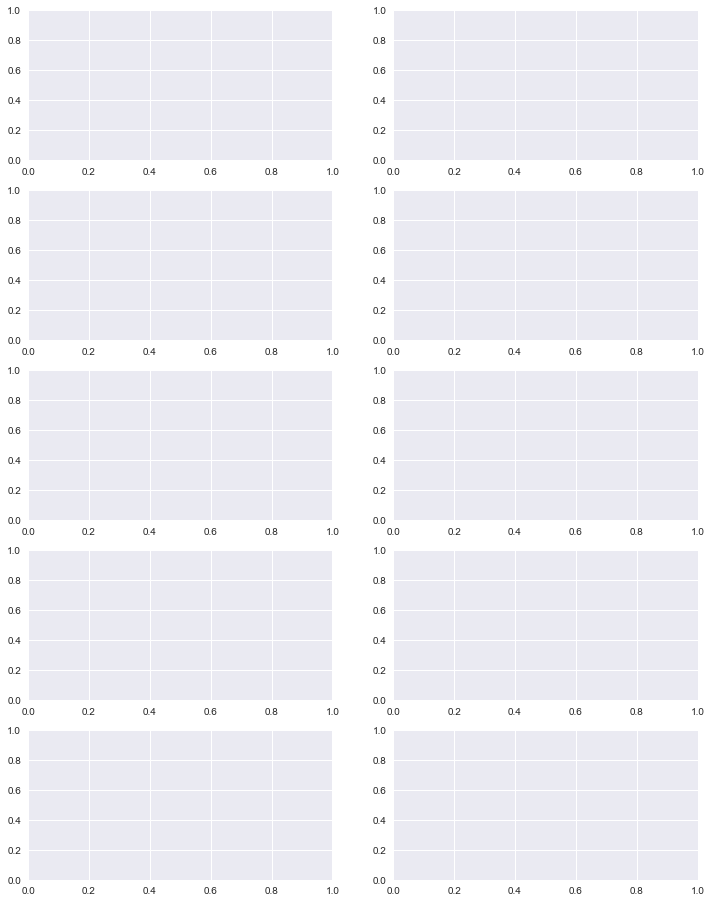

In [13]:
#3. Plot Comparison between Actual and Predicted Results
if data_type == 'simulated':
    real_vs_predicted = plot_species_curves(modelDict, 'title', tsdf, targets, specific_features,train_sizes=train_sizes,training_sets=training_sets)
    plt.savefig('figures/MainFigure.pdf')
    
    
elif data_type == 'experimental':
    #Fit each test strain by solving the differential equation

    #Select Random Time Series
    strains = test_df.index.get_level_values(0).unique()
    random_strain = random.sample(tuple(strains), 1)
    random_strain = list(random_strain)[0]
    random_df = test_df.loc[(slice(random_strain,random_strain),slice(None)),:]

    #Set Y0 initial condition
    y0 = random_df[targets].iloc[0].tolist()
    print('y0',y0)
    
    #Create Differential Equation to Solve
    if featureReduction:
        target_features = [header[1:]]*len(targets[0])
        g = mlode(modelDict, random_df, targets, specific_features)
    else:
        g = mlode(modelDict, random_df, targets, specific_features,time_index='Time')

    #Solve Differential Equation numerically using a runge-kutta 4,5 implementation
    times = random_df.reset_index()['Time'].tolist()
    fit = odeintz(g,y0,times)
    fitT = list(map(list, zip(*fit)))
    
    
    #Create Interpolation functions for each feature
    interpFun = {}
    for feature in random_df.columns:
        X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
        interpFun[feature] = interp1d(X,y)

        
    if pathway == 'limonene':
        #print(random_df.columns)
        proteins = ['AtoB', 'HMGR', 'HMGS', 'MK', 'PMD', 'PMK','Limonene Synthase']
        protein_fcns= []
        for feature in random_df.columns:
            X,y = remove_NaN(random_df.reset_index()['Time'].tolist(),random_df[feature].tolist())
            protein_fcns.append(interp1d(X,y))
        
        #Generate Fit Kinetic Model ODE
        def kinetic_ode(x,t,proteomic_fcns):
            
            #proteomics 
            proteomic_data = [proteomic_fcn(t) for proteomic_fcn in proteomic_fcns]

            params = []
            params.extend(proteomic_data[0:6]) # AtoB to PMD Values
            params.extend(best_params[0:2])     # Keep Constant GPPS and IDI levels as free parameters
            params.append(proteomic_data[6])   # 
            params.append(x[0])                #Acetyl-CoA
            params.append(best_params[2])       # AcetoAcetyl-CoA as a free Param
            params.extend(x[1:4])               # HMG-CoA & Mev & MevP measured
            params.append(best_params[3])       # MevPP 
            params.extend([x[4],x[4]])          # DMAPP & IDI Measured
            params.extend([best_params[4],x[5]]) # GPP as a Free Parameter #Measured Limonene Synthase
            params.extend(best_params[5:])      # Remaining Kinetic Free Parameters
            
            
            dxdt = kinetic_model(*params)
            dxdt_combined = [dxdt[0],dxdt[2],dxdt[3],dxdt[4],dxdt[6]+dxdt[7],dxdt[9]]
            return dxdt_combined
        
        for protein in proteins:
            protein_fcns.append(interpFun[protein])
        
        #Solve Kinetic ODE at initial Conditions
        kinetic_ode_p = lambda x,t : kinetic_ode(x,t,protein_fcns)
        kinetic_fit = odeintz(kinetic_ode_p,y0,times)
        kinetic_fit = list(map(list, zip(*kinetic_fit)))
        
    real_vs_predicted = {}
    plt.figure(figsize=(12,8))
    for i,target in enumerate(targets):
        plt.subplot(2,3,i+1)
        if data_type == 'experimental':
            #Plot both High and Low Strain values
            for strain in training_strains:
                strainInterpFun = {}
                strain_df = df.loc[(strain,slice(None))]
                X,y = remove_NaN(strain_df.reset_index()['Time'].tolist(),strain_df[target].tolist())
                strainInterpFun[target] = interp1d(X,y)
                actual_data = [strainInterpFun[target](t) for t in times]
                train_line, = plt.plot(times,actual_data,'r--')
            
            #Plot Kinetic Model Fit
            if pathway =='limonene':
                kinetic_pred = [max(kinetic_fit[i][j],0) for j,t in enumerate(times)]
                kinetic_line, = plt.plot(times,kinetic_pred,color='k')

        actual_data = [interpFun[target](t) for t in times]
        pos_pred = [max(fitT[i][j],0) for j,t in enumerate(times)]
        prediction_line, = plt.plot(times,pos_pred)
        #print(actual_data)
        test_line, = plt.plot(times,actual_data,'g--')
        plt.ylabel(target)
        plt.xlabel('Time [h]')
        plt.xlim([0,72])
        
        if i == 5 and pathway == 'limonene':
            plt.ylim([0,0.6])
        
        #Create variable for processing error residuals
        if pathway == 'limonene':
            real_vs_predicted[target] = [times,actual_data,pos_pred,kinetic_pred]
        else:
            real_vs_predicted[target] = [times,actual_data,pos_pred]
    #Add Legend
    if set_num==2:
        product = 'Isopentenol'
    elif set_num==3:
        product = 'Limonene'
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.subplots_adjust(bottom=0.12)
    plt.suptitle('Prediction of ' + product + ' Strain Dynamics', fontsize=18)
    if pathway == 'limonene':
        plt.figlegend( (train_line,test_line,prediction_line,kinetic_line), ('Training Set Data','Test Data','Machine Learning Model Prediction','Kinetic Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. )  
    else:
        plt.figlegend( (train_line,test_line,prediction_line), ('Training Set Data','Test Data','Machine Learning Model Prediction'), loc = 'lower center', ncol=5, labelspacing=0. ) 
    plt.savefig('data/' + product + '_prediction.eps', format='eps', dpi=600)
    plt.show()

In [ ]:
#4. Error Residuals of Time Series Data + Key Moments Report

#Not Quite Right... Need to Integrate over the 
if data_type == 'experimental':
    #print(real_vs_predicted)

    rmse_percent = []
    rmse_average = []
    rmse_percent_k = []
    rmse_average_k = []
    for metabolite in real_vs_predicted:
        if pathway == 'limonene':
            times,real,predicted,kinetic = real_vs_predicted[metabolite]
        else:
            times,real,predicted = real_vs_predicted[metabolite]
        real_fcn = interp1d(times,real)
        pred_fcn = interp1d(times,predicted)

        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
        rmse = math.sqrt(quad(integrand,min(times),max(times))[0])
        rmse_average.append(rmse)
        percent_integrand = lambda t: abs(real_fcn(t) - pred_fcn(t))/(real_fcn(t)*max(times))
        #print(metabolite,[percent_integrand(t) for t in times],[real_fcn(t) for t in times],[pred_fcn(t) for t in times])
        
        rmsep = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
        rmse_percent.append(rmsep)
        print('ML Fit:',metabolite,rmse,'RMSE percent:',rmsep*100)
        
        if pathway == 'limonene':
            kinetic_fcn = interp1d(times,kinetic)
            integrand = lambda t: (real_fcn(t) - kinetic_fcn(t))**2
            rmsek = math.sqrt(quad(integrand,min(times),max(times))[0])
            percent_integrand = lambda t: abs(real_fcn(t) - kinetic_fcn(t))/(real_fcn(t)*max(times))
            rmsepk = math.sqrt(quad(percent_integrand,min(times),max(times))[0])
            rmse_percent_k.append(rmsepk)
            rmse_average_k.append(rmsek)
            print('Kinetic Fit:',metabolite,rmsek,'RMSE percent:',rmsepk*100)
    
    print('')
    print('Machine Learning Model Agrigate Error')
    print('Average RMSE:',sum(rmse_average)/len(rmse_average))
    print('Total Percent Error:',sum(rmse_percent)/len(rmse_percent)*100)

    if pathway == 'limonene':
        print('')
        print('Kinetic Model Agrigate Error')
        print('Average RMSE:',sum(rmse_average_k)/len(rmse_average_k))
        print('Total Percent Error:',sum(rmse_percent_k)/len(rmse_percent_k)*100)
        
elif data_type == 'simulated':
    times = real_vs_predicted['Time']
    rmse_dict = {}
    for metabolite in real_vs_predicted:
        if metabolite not in ['Time',]:
            actual = real_vs_predicted[metabolite]['actual']
            real_fcn = interp1d(times,actual)
            rmse_dict[metabolite] = {}
            for test_size in real_vs_predicted[metabolite]:
                print(metabolite,'Test Size:',test_size)
                total_rmse = []
                if test_size not in ['Time','actual']:
                    #For Each Test Size Produce Values + Moments Reporting...
                    rmse = []
                    for test_strain in enumerate(real_vs_predicted[metabolite][test_size]):
                        #print(test_strain)
                        pred_fcn = interp1d(times,test_strain[1])
                        integrand = lambda t: (real_fcn(t) - pred_fcn(t))**2
                        rmse.append(math.sqrt(quad(integrand,min(times),max(times))[0]))
                        
                    #Report Moments for each Test Size
                    rmse_dict[metabolite][test_size] = rmse
                    print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
                    print('RMSEs:',rmse)
                    print('')
                    

    #Calculate Mean Total Error + Mean Standard Deviation for Composite Error
    size_dict = {}
    for metabolite in rmse_dict:
        for test_size in rmse_dict[metabolite]:
            size_dict[test_size] = [0]*len(rmse_dict[metabolite][test_size])
            size_dict[test_size] = [s + r for s,r in zip(rmse_dict[metabolite][test_size],size_dict[test_size])]

    #Print out Agrigate Statistics
    for test_size in size_dict:
        rmse = size_dict[test_size]
        print('Test Size for Agrigate Statistics:',test_size)
        print('Mean RMSE:',np.mean(rmse),'Standard Deviation RMSE:',np.std(rmse))
        print('RMSEs:',rmse)
        print('')
        
        
    

In [ ]:
if data_type == 'simulated':
        
    #Plot Agrigate Statistics in the form of a bar graph...
    sizes = list(size_dict.keys())
    means = [np.mean(size_dict[size]) for size in sizes]
    stdevs = [np.std(size_dict[size]) for size in sizes]
    y_pos = np.arange(len(sizes))

    #Calculate Percent Errors              
    #for size in sizes:
    #    for training_set in training_sets:
    #        percent_integrand = lambda t: abs(real_fcn(t) - kinetic_fcn(t))/(real_fcn(t)*max(times))
        
    plt.bar(y_pos, means, align='center',yerr=stdevs)
    plt.xticks(y_pos, sizes)
    plt.ylabel('RMSE')
    plt.xlabel('Training Set Size')
    plt.title('RMSE vs Training Set Size')
    plt.savefig('figures/RMSEvsSize.pdf')
    
    plt.show()

In [ ]:
#Perform Analysis to See if Learned Model Can predict the best & Worst producers from 100 strains

def predict_production(modelDict,strain,tsdf):
    #Use Model To figure out production using dynamics
    #Set Y0 initial condition
    #display(tsdf)
    #y0_targets = pd.MultiIndex.from_tuples([('feature',target) for target in targets])
    strain_df = tsdf.loc[tsdf.index.get_level_values(0) == strain]
    y0 = strain_df.loc[:,tsdf.columns.isin(targets)].iloc[0]
    y0 = y0.reindex(targets).values
    
    #Create Differential Equation to Solve
    g = mlode(modelDict, strain_df, targets, specific_features, time_index='Time')

    #Solve Differential Equation numerically using a runge-kutta 4,5 implementation
    times = strain_df.reset_index()['Time'].tolist()
    fit = odeintz(g,y0,times)
    fitT = list(map(list, zip(*fit)))
    
    #print(fitT[-1])
    production = fitT[-1][-1]
    
    #Return Producion at the final time point
    return production

In [ ]:
def mlode(modelDict, df, targets, specific_features,time_index='Time (h)'):
    #print(specific_features)
    #print(targets)
    
    #Create Interpolation functions for each feature
    ml_interpFun = {}
    #display(df)
    #df = df['feature']
    for feature in df.columns:
        #print(feature)
        if feature not in targets:
            #print(feature)
            X,y = remove_NaN(df.reset_index()[time_index].tolist(),df[feature].tolist())
            if isinstance(feature,tuple):
                feature = feature[1]
            ml_interpFun[feature] = interp1d(X,y)
        
    #print([key for key in ml_interpFun])
    #Define the function to integrate
    def f(x,t):
        x_dot = []
        #Generate Derivatives for Each Target
        for target in targets:
            x_pred = []
            for feature in df.columns:
                #If the Feature is dynamically changing, use the Dynamic Value
                if feature in targets:
                    x_pred= np.append(x_pred, x[targets.index(feature)])
                
                #Otherwise use a value parameterized by time
                else:
                    x_pred= np.append(x_pred, ml_interpFun[feature](t))
            
            #Append the Predicted Derivative to the output vector
            #print(x_pred)
            model_prediction = modelDict[target].predict([x_pred])
            #print(x_dot,model_prediction)
            x_dot = np.append(x_dot,model_prediction)
                
        return x_dot
    return f

In [ ]:
num_trials = 10
if data_type == 'simulated':
    
    strain_numbers = list(test_tsdf.index.get_level_values(0).unique())
    strain_lists = random.sample(strain_numbers,100*num_trials)
    strain_lists = [strain_lists[x:x+100] for x in range(0, len(strain_lists), 100)]
    
    actual_max_ranks = []
    actual_min_ranks = []
    actual_min_productions = []
    actual_max_productions = []
    prediction_errors = []
    productions = []
    actual_productions = []
    for strain_list in strain_lists:
        
        #Sort Chosen Strains by production & Reindex by Rank
        strain_list_index = pd.MultiIndex.from_tuples([(strain,69.0) for strain in strain_list])
        actual_production_df = test_tsdf.loc[test_tsdf.index.isin(strain_list_index),('feature','Limonene')].to_frame()
        actual_production_df.columns = ['Limonene']
        actual_production_df = actual_production_df.sort_values('Limonene',axis=0).reset_index()
        actual_production_df = actual_production_df[['Strain','Limonene']]
        #display(actual_production_df)
        
    
        #Use Model To Predict Production For all Strains
        min_production = float('inf')
        max_production = 0
        display(actual_production_df)
        for strain in strain_list:
            production = predict_production(modelDict,strain,test_tsdf)
            actual_production = actual_production_df.loc[actual_production_df['Strain']==strain,'Limonene'].values[0]
            print(production,actual_production)
            
            #Select Best and Worst Strains
            if production < min_production:
                min_production = production
                actual_min_production = actual_production
                min_strain = strain
                
            if production > max_production:
                max_production = production
                actual_max_production = actual_production
                max_strain = strain
            
            productions.append(actual_production)
            actual_productions.append(production)
            prediction_errors.append(production - actual_production)
            
            print('minimum producing strain ({}) produces {:.4f} g/L'.format(min_strain,min_production))
            print('maximum producing strain ({}) produces {:.4f} g/L'.format(max_strain,max_production))
            
        #Calculate Strain Ranks
        actual_max_ranks.append(actual_production_df.loc[actual_production_df['Strain']==max_strain].index)
        actual_min_ranks.append(actual_production_df.loc[actual_production_df['Strain']==min_strain].index)
        
        #Calculate Predicted Highest Production / Actual Highest Production
        actual_max_productions.append(actual_max_production)
        actual_min_productions.append(actual_min_production)
    
    #Do Hectors Analysis

In [ ]:
#Plot all findings from Production Prediction Experiment!
if data_type == 'simulated':
    #Plot Average Rank Predicted for Min / Max Strains (And Compute/ Present Statistics)
    print(np.mean(actual_max_ranks)+1,np.std(actual_max_ranks))
    print(np.mean(actual_min_ranks)+1,np.std(actual_min_ranks))
    
    fig=plt.figure()
    ax = plt.gca()
    plt.bar(np.arange(2),[100-np.mean(actual_max_ranks),np.mean(actual_min_ranks)+1],yerr=[np.std(actual_max_ranks),np.std(actual_min_ranks)],align='center')
    ax.set_xticks([0,1])
    ax.set_xticklabels(('Min Producing Strain Rank Error','Max Producing Strain Rank Error'))
    plt.title('Average Predicted Rank (Best Rank is 1/Worst Rank is 100)')
    plt.savefig('figures/rank_prediction.pdf')
    plt.show()
    
    #Plot Predicted Max vs Actual Max for each Set
    #plt.scatter(actual_max_productions,actual_min_productions)
    #plt.show()
    
    #Plot Production Error histogram (And Compute/Present Statistics)
    print('95% of all predicted strain productivities are within {:.2f} mg/L Limonene.'.format(np.std(prediction_errors)*2*1000))
    sns.distplot(prediction_errors)
    plt.title('Prediction Error of Limonene (g/L)')
    plt.xlabel('Error in Predicting Final Limonene Production (g/L)')
    plt.ylabel('Probability Density')
    plt.savefig('figures/prediction_error_distribution.pdf')
    plt.show()
    
    plot_model_fit('Limonene',productions,actual_productions)    
    plt.savefig('figures/final_production_error_residuals.pdf')
    plt.show()

    

In [ ]:
#Build Final Figure for Hector 2/10/100 (How Many Strains does it get Correct??)
#Pick 100 sets of 3 10 times and see if the order matches

sizes = [100,10,2]
training_strains = list(tsdf.index.get_level_values(0).unique())
test_strains = list(test_tsdf.index.get_level_values(0).unique())
training_strains = np.reshape(random.sample(training_strains,10*sizes[0]),(10,-1))
#print(training_strains)
success_dict = {100:[],10:[],2:[]}
for trial in range(10):
    
    #Generate 100 Sets of 3 (With Replacement)
    test_sets = [random.choices(test_strains,k=3) for _ in range(100)]
    
    #Train Model on different number of strains
    substrains = None
    for size in sizes:
        print(trial,size)
        #Pick Strains To Train On
        if substrains is None:
            substrains = training_strains[trial]
        else:
            #sample a set of the substrains with cardinality of size
            substrains = random.sample(set(substrains),size)
        
        #Generate features (X) and targets (y)
        X = tsdf['feature'].loc[tsdf.index.get_level_values(0).isin(substrains)].values

        #Train Models
        for key in modelDict:
            y = tsdf['target'].loc[tsdf.index.get_level_values(0).isin(substrains),tsdf['target'].columns == key].values.ravel()
            modelDict[key].fit(X,y)
        
        print('predict production')
        #For Each test set try to predict order (high / medium / low)
        successes = 0
        for i in range(100):
            #print(test_sets[i])
        
            strain_list_index = pd.MultiIndex.from_tuples([(strain,69.0) for strain in test_sets[i]])
            actual_production_df = test_tsdf.loc[test_tsdf.index.isin(strain_list_index),('feature','Limonene')].to_frame()
            actual_production_df.columns = ['Limonene']
            actual_production_df = actual_production_df.sort_values('Limonene',axis=0).reset_index()
            actual_production_df = actual_production_df[['Strain','Limonene']]
            sorted_strains = actual_production_df['Strain']
            #display(actual_production_df)
            
            
            productions = [ ]
            #if production is always increasing... then label a success
            for test_strain in sorted_strains:
                productions.append(predict_production(modelDict,test_strain,test_df))
                
            if productions[0] < productions[1] and productions[1] < productions[2]:
                print('Success!')
                successes += 1
            else:
                print('Failure')
            
            print(productions)
            print(i,successes/(i+1))
            display(actual_production_df)

            #print(productions,test_sets[i])
            
        success_dict[size].append(successes)          

In [ ]:
#Also have a random chance bar at a probabilty of (1/6) or n! percent